# Image classification with Swin Transformers

**Author:** [Rishit Dagli](https://twitter.com/rishit_dagli)<br>
**Date created:** 2021/09/08<br>
**Last modified:** 2021/09/08<br>
**Description:** Image classification using Swin Transformers, a general-purpose backbone for computer vision.

This example implements
[Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030)
by Liu et al. for image classification, and demonstrates it on the
[CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Swin Transformer (**S**hifted **Win**dow Transformer) can serve as a
general-purpose backbone for computer vision. Swin Transformer is a hierarchical
Transformer whose representations are computed with _shifted windows_. The
shifted window scheme brings greater efficiency by limiting self-attention
computation to non-overlapping local windows while also allowing for
cross-window connections. This architecture has the flexibility to model
information at various scales and has a linear computational complexity with
respect to image size.

This example requires TensorFlow 2.5 or higher.

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # For tf.data and preprocessing only.
print(tf.config.list_physical_devices('GPU'))
import keras
from keras import layers
from keras import ops
import cv2
import imutils
import random

2024-02-01 14:48:44.629656: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 14:48:44.629725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 14:48:44.665899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 14:48:44.741874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 14:48:45.613912: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-01 14:48:48.739972: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 14:48:48.863996: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 14:48:48.865485: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Configure the hyperparameters

A key parameter to pick is the `patch_size`, the size of the input patches.
In order to use each pixel as an individual input, you can set `patch_size` to
`(1, 1)`. Below, we take inspiration from the original paper settings for
training on ImageNet-1K, keeping most of the original settings for this example.

In [2]:
num_classes = 33
input_shape = (32,32,1)

patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
# Convert embedded patches to query, key, and values with a learnable additive
# value
qkv_bias = True
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 16
num_epochs = 200
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

## Prepare the data

We load the CIFAR-100 dataset through `keras.datasets`,
normalize the images, and convert the integer labels to one-hot encoded vectors.

(32, 32)


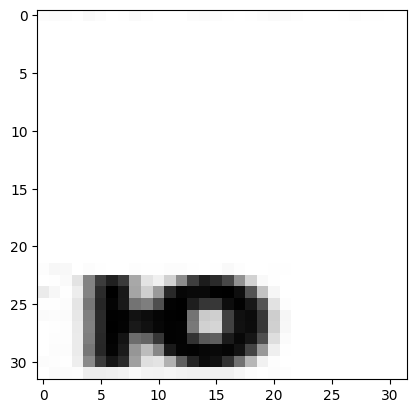

In [3]:
let = cv2.imread('data/letterlist.jpg', 0)
let = let[15:780,:]
num_letters = 33
num_fonts = 21

def get_letter(font_num, letter_num):
    letter = let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]
    return cv2.resize(letter, input_shape[:-1])

def get_letter_variants(letter_num):
        return let[:,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]

def get_font_variants(font_num):
    return let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           :,
           ]
test = get_letter(21,33)
print(test.shape)
plt.imshow(test, cmap='gray')

In [4]:
class BaseAugmenter():
    def __init__(self, chanse=0.5):
        self.chance = chanse
        
    def __call__(self, img, *args, **kwargs):
        augmented = False
        if random.random()<= self.chance:
            try:
                img = self._apply(img, *args, **kwargs)
                augmented = True
            except Exception as e:
                print(e)
            
        return img, augmented
    
    def _apply(self, img, *args, **kwargs):
        return img
    
class NoiseAugmenter(BaseAugmenter):
    def _apply(self, letter, max=30):
        noise = np.random.normal(size=(letter.shape))*max
        return letter+noise
    
class FlipAugmenter(BaseAugmenter):

    def _apply(self, letter, mode='horizontal'):
        if mode == 'horizontal':
            return np.flip(letter, axis=0)
        elif mode == 'vertical':
            return np.flip(letter, axis=1)
        elif mode == 'random':
            axis = random.random() < 0.5
            return np.flip(letter, axis=int(axis))
        
class RotationAugmenter(BaseAugmenter):
    
    def _apply(self, letter, angle=60):
        image = np.zeros_like(letter) + 255 - letter
        rotated = imutils.rotate_bound(image, angle)
        rotated = np.zeros_like(rotated) + 255 - rotated
        rotated = cv2.resize(rotated, (letter.shape[1], letter.shape[0]))
        return rotated
    
class BlurAugmenter(BaseAugmenter):
    
    def _apply(self, letter, kernel_size=3):
        return cv2.medianBlur(letter, kernel_size)

class MultipleAugmenter():
    NOISE_CHANCE = 0.1
    NOISE_HARDNESS = 20
    
    FLIP_CHANCE = 0.3
    
    ROTATE_CHANCE = 0.15
    
    BLUR_CHANCE = 0.1
    BLUR_HARD_CHANCE = 0.05
    
    images = []
    captions = []
    
    def __init__(self, images, captions):
        self.images_orig = images
        self.captions_orig = captions
        self.augmenters = [
            FlipAugmenter(self.FLIP_CHANCE),
            RotationAugmenter(self.ROTATE_CHANCE),
            BlurAugmenter(self.BLUR_CHANCE),
            BlurAugmenter(self.BLUR_HARD_CHANCE),
            
        ]
        self.noise = (NoiseAugmenter(self.NOISE_CHANCE), self.NOISE_HARDNESS)
        
        self.augment_args = [
            ['random'],
            [],
            [3],
            [5],

        ]    
    
    def random_augment(self, rounds = 1, seed = 42, save_last=False):
        random.seed(seed)
        
        images = self.images_orig
        captions = self.captions_orig
        
        for _ in range(rounds):
            print(len(images))
            num_images = len(images)
            for n in range(num_images):
                image = images[n]
                caption = captions[n]
                
                for n, aug in enumerate(self.augmenters):
                    aug_args = self.augment_args[n]
                    if not aug_args:
                        aug_args = [random.randint(-15,15)]
                    image, augmented = aug(image, *aug_args)
                    if augmented:
                        images.append(image)
                        captions.append(caption)
                    
            if save_last:
                images = images[num_images:]
                captions = captions[num_images:]
        

                
        self.images = images
        self.captions = captions        
        self._apply_noise()
        self._normalize()
        
    def _apply_noise(self):
        for n, im in enumerate(self.images):
            noise_augmenter, hardeness = self.noise
            image, augmented = noise_augmenter(im, hardeness)
            if augmented:
                self.images[n] = image        
        
    def _normalize(self):
        for n, im in enumerate(self.images):
            im = np.array(im)
            self.images[n] = im/im.max()

In [5]:
images = []
captions = []
captions_base = "Ё Й Ц У К Е Н Г Ш Щ З Х Ъ Ф Ы В А П Р О Л Д Ж Э Я Ч С М И Т Ь Б Ю".split(' ')
for i in range(1, num_fonts+1):
    for j in range(1, num_letters+1):
        images.append(get_letter(i,j))
        captions.append(captions_base[j-1])

aug = MultipleAugmenter(images.copy(), captions.copy())
aug.random_augment(8)
test_aug = MultipleAugmenter(images.copy(), captions.copy())
test_aug.random_augment(3, 65, 0)

693
1117
1763
2814
4490
7161
11452
18331
693
1099
1727


In [6]:
x_data = np.array(aug.images)
x_data = x_data.reshape(*x_data.shape, 1)
classes = list(map(captions_base.index, aug.captions))
y_data = keras.utils.to_categorical(classes, num_classes=num_letters)

num_train_samples = int(len(x_data) * (1 - validation_split))
num_val_samples = len(x_data) - num_train_samples
x_train, x_val = np.split(x_data, [num_train_samples])
y_train, y_val = np.split(y_data, [num_train_samples])

test_x_data = np.array(test_aug.images)
test_x_data = test_x_data.reshape(*test_x_data.shape,1)

test_classes = list(map(captions_base.index, test_aug.captions))
test_y_data = keras.utils.to_categorical(test_classes, num_classes=num_letters)

## Helper functions

We create two helper functions to help us get a sequence of
patches from the image, merge patches, and apply dropout.

In [7]:

def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        x,
        (
            -1,
            patch_num_y,
            window_size,
            patch_num_x,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = ops.reshape(x, (-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        windows,
        (
            -1,
            patch_num_y,
            patch_num_x,
            window_size,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    x = ops.reshape(x, (-1, height, width, channels))
    return x


## Window based multi-head self-attention

Usually Transformers perform global self-attention, where the relationships
between a token and all other tokens are computed. The global computation leads
to quadratic complexity with respect to the number of tokens. Here, as the
[original paper](https://arxiv.org/abs/2103.14030) suggests, we compute
self-attention within local windows, in a non-overlapping manner. Global
self-attention leads to quadratic computational complexity in the number of
patches, whereas window-based self-attention leads to linear complexity and is
easily scalable.

In [8]:
class WindowAttention(layers.Layer):
    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=keras.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = keras.Variable(
            initializer=relative_position_index,
            shape=relative_position_index.shape,
            dtype="int",
            trainable=False,
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = ops.reshape(x_qkv, (-1, size, 3, self.num_heads, head_dim))
        x_qkv = ops.transpose(x_qkv, (2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = ops.transpose(k, (0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = ops.reshape(self.relative_position_index, (-1,))
        relative_position_bias = ops.take(
            self.relative_position_bias_table,
            relative_position_index_flat,
            axis=0,
        )
        relative_position_bias = ops.reshape(
            relative_position_bias,
            (num_window_elements, num_window_elements, -1),
        )
        relative_position_bias = ops.transpose(relative_position_bias, (2, 0, 1))
        attn = attn + ops.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.shape[0]
            mask_float = ops.cast(
                ops.expand_dims(ops.expand_dims(mask, axis=1), axis=0),
                "float32",
            )
            attn = ops.reshape(attn, (-1, nW, self.num_heads, size, size)) + mask_float
            attn = ops.reshape(attn, (-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = ops.transpose(x_qkv, (0, 2, 1, 3))
        x_qkv = ops.reshape(x_qkv, (-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv


## The complete Swin Transformer model

Finally, we put together the complete Swin Transformer by replacing the standard
multi-head attention (MHA) with shifted windows attention. As suggested in the
original paper, we create a model comprising of a shifted window-based MHA
layer, followed by a 2-layer MLP with GELU nonlinearity in between, applying
`LayerNormalization` before each MSA layer and each MLP, and a residual
connection after each of these layers.

Notice that we only create a simple MLP with 2 Dense and
2 Dropout layers. Often you will see models using ResNet-50 as the MLP which is
quite standard in the literature. However in this paper the authors use a
2-layer MLP with GELU nonlinearity in between.

In [9]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = layers.Dropout(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = ops.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = ops.reshape(
                mask_windows, [-1, self.window_size * self.window_size]
            )
            attn_mask = ops.expand_dims(mask_windows, axis=1) - ops.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = ops.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = ops.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = keras.Variable(
                initializer=attn_mask,
                shape=attn_mask.shape,
                dtype=attn_mask.dtype,
                trainable=False,
            )

    def call(self, x, training=False):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = ops.reshape(x, (-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = ops.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = ops.reshape(
            x_windows, (-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = ops.reshape(
            attn_windows,
            (-1, self.window_size, self.window_size, channels),
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = ops.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = ops.reshape(x, (-1, height * width, channels))
        x = self.drop_path(x, training=training)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x


## Model training and evaluation

### Extract and embed patches

We first create 3 layers to help us extract, embed and merge patches from the
images on top of which we will later use the Swin Transformer class we built.

In [10]:
# Using tf ops since it is only used in tf.data.
def patch_extract(images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=(1, patch_size[0], patch_size[1], 1),
        strides=(1, patch_size[0], patch_size[1], 1),
        rates=(1, 1, 1, 1),
        padding="VALID",
    )
    patch_dim = patches.shape[-1]
    patch_num = patches.shape[1]
    return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))

class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch)
        return self.proj(patch) + self.pos_embed(pos)

class PatchMerging(keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.shape
        x = ops.reshape(x, (-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = ops.concatenate((x0, x1, x2, x3), axis=-1)
        x = ops.reshape(x, (-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)


### Prepare the tf.data.Dataset

We do all the steps, which do not have trainable weights with tf.data.
Prepare the training, validation and testing sets.

In [11]:
def augment(x):
    return x


dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(lambda x, y: (augment(x), y))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_val = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_test = (
    tf.data.Dataset.from_tensor_slices((test_x_data, test_y_data))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

2024-02-01 14:48:50.374837: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 14:48:50.376363: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 14:48:50.377714: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
len(test_x_data)

2788

### Build the model

We put together the Swin Transformer model.

In [13]:
input = layers.Input(shape=(256, 4))
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(input)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
dense = keras.layers.Dense(1024, activation='relu')(x)
dense = keras.layers.Dense(512, activation='relu')(dense)
dense = keras.layers.Dense(256, activation='relu')(dense)
output = layers.Dense(num_classes, activation="softmax")(dense)
model = keras.Model(input, output)
model.summary()

2024-02-01 14:48:51.585637: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 4)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ patch_embedding                 │ (None, 256, 64)           │     16,704 │
│ (PatchEmbedding)                │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ swin_transformer                │ (None, 256, 64)           │     50,072 │
│ (SwinTransformer)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ swin_transformer_1              │ (None, 256, 64)           │     51,096 │
│ (SwinTransformer)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ patch_merging (PatchMerging)    │ (None, 64, 128)           │     32,768 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling1d        │ (None, 128)               │          0 │
│ (GlobalAveragePooling1D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ (None, 1024)              │    132,096 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_12 (Dense)                │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_13 (Dense)                │ (None, 33)                │      8,481 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 947,345 (3.62 MB)

 Trainable params: 946,289 (3.61 MB)

 Non-trainable params: 1,056 (8.25 KB)

In [14]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_delta = 1e-4,
                              patience=3, min_lr=1e-10)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=7, start_from_epoch=30)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs")
checkpoint_filepath = f"tmp/swin_checkpoint.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_categorical_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

callbacks = [reduce_lr, early_stop, tensorboard]

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    dataset,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=dataset_val,
    callbacks= callbacks
)

Epoch 1/200


2024-02-01 14:48:56.837871: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f35f4432c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-01 14:48:56.837904: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-02-01 14:48:57.037390: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-01 14:48:58.283970: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


  16/1648 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0311 - loss: 3.6726 - top-5-accuracy: 0.1180

I0000 00:00:1706788149.095720    3790 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1648/1648 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.0309 - loss: 3.5107 - top-5-accuracy: 0.1560 - val_accuracy: 0.0294 - val_loss: 3.5414 - val_top-5-accuracy: 0.1697 - learning_rate: 0.0010
Epoch 2/200
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0440 - loss: 3.4487 - top-5-accuracy: 0.2171 - val_accuracy: 0.0546 - val_loss: 3.4471 - val_top-5-accuracy: 0.2427 - learning_rate: 0.0010
Epoch 3/200
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0628 - loss: 3.3321 - top-5-accuracy: 0.2859 - val_accuracy: 0.0686 - val_loss: 3.3452 - val_top-5-accuracy: 0.2738 - learning_rate: 0.0010
Epoch 4/200
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0750 - loss: 3.2800 - top-5-accuracy: 0.3082 - val_accuracy: 0.0751 - val_loss: 3.3318 - val_top-5-accuracy: 0.3107 - learning_rate: 0.0010
Epoch 5/200
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0972 - loss: 3.2044 - top-5-accuracy: 0.3704 - val_accuracy: 0.1205 - val_loss: 3.2009 - val_top-5-ac

Let's visualize the training progress of the model.

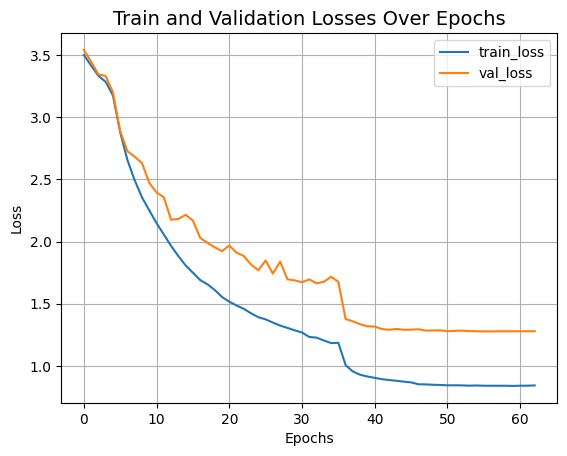

In [15]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [16]:
# loss, accuracy, top_5_accuracy = model.evaluate(dataset_test)
# print(f"Test loss: {round(loss, 2)}")
# print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

In [46]:
model.save('models/swin.keras')
model.save_weights('models/swin.weights.h5')

In [18]:
# keras.utils.plot_model(model,'models/swin.jpg')

In [19]:
# model.load_weights('tmp/checkpoint81.weights.h5')

# Load other models to compare

In [20]:
ViT = keras.saving.load_model('models/vit_letter_recognizer.keras')
ViT.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

In [41]:
CNN = keras.saving.load_model('models/conv_letter_recognizer.keras')
CNN.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

In [42]:
models = [CNN, ViT]

In [43]:
evals = []
for m in models: 
    evals.append(m.evaluate(test_x_data, test_y_data))
evals.append(model.evaluate(dataset_test))
evals

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1437 - loss: 3.4287 - top-5-accuracy: 0.4113
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8822 - loss: 1.9255 - top-5-accuracy: 0.9570
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9242 - loss: 0.9550 - top-5-accuracy: 0.9830


[[3.4349968433380127, 0.1345050185918808, 0.3927546739578247],
 [2.431652307510376, 0.7758249640464783, 0.9031563997268677],
 [1.1309446096420288, 0.8644189238548279, 0.9623385667800903]]

In [28]:
preds = []

for m in models: 
    preds.append(m.predict(test_x_data))
preds.append(model.predict(dataset_test))

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [29]:
test_x_data.shape

(2788, 32, 32, 1)

In [30]:
CNN.summary(), ViT.summary(), model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 32, 32, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 128)       │      1,280 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 256)       │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 512)         │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 8192)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1024)              │  8,389,632 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 33)                │      8,481 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 10,530,849 (40.17 MB)

 Trainable params: 10,530,849 (40.17 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ reshape (Reshape)               │ (None, 32, 32)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder             │ (None, 32, 32)            │     69,896 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_1           │ (None, 32, 32)            │     69,896 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_2           │ (None, 32, 32)            │     69,896 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_3           │ (None, 32, 32)            │     69,896 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 1024)              │  1,049,600 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 33)                │      8,481 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,993,793 (7.61 MB)

 Trainable params: 1,993,793 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 4)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ patch_embedding                 │ (None, 256, 64)           │     16,704 │
│ (PatchEmbedding)                │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ swin_transformer                │ (None, 256, 64)           │     50,072 │
│ (SwinTransformer)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ swin_transformer_1              │ (None, 256, 64)           │     51,096 │
│ (SwinTransformer)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ patch_merging (PatchMerging)    │ (None, 64, 128)           │     32,768 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling1d        │ (None, 128)               │          0 │
│ (GlobalAveragePooling1D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ (None, 1024)              │    132,096 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_12 (Dense)                │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_13 (Dense)                │ (None, 33)                │      8,481 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,839,925 (10.84 MB)

 Trainable params: 946,289 (3.61 MB)

 Non-trainable params: 1,056 (8.25 KB)

 Optimizer params: 1,892,580 (7.22 MB)

(None, None, None)

In [35]:
y_pred = model.predict(dataset_test).argmax(axis=1)

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [40]:
len(dataset_test.unbatch())

TypeError: The dataset length is unknown.

In [ ]:

mat = np.zeros(shape=(num_letters,num_letters))
for i in range(len(y_pred)):
    true_ind = test_classes[i]
    pred_ind = y_pred[i]    
    mat[true_ind, pred_ind]+=1

mat=mat/mat.sum(axis=0)

fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(mat, cmap='Blues')
ax.set_xticks(range(len(captions_base)), captions_base)
ax.set_yticks(range(len(captions_base)), captions_base)
for i in range(len(captions_base)):
    for j in range(len(captions_base)):
        c = mat[j,i]
        ax.text(i, j, f'{c:.2f}', va='center', ha='center')
ax.set_xlabel('True letters', fontsize=15)
ax.set_ylabel('Predicted letters', fontsize=15)

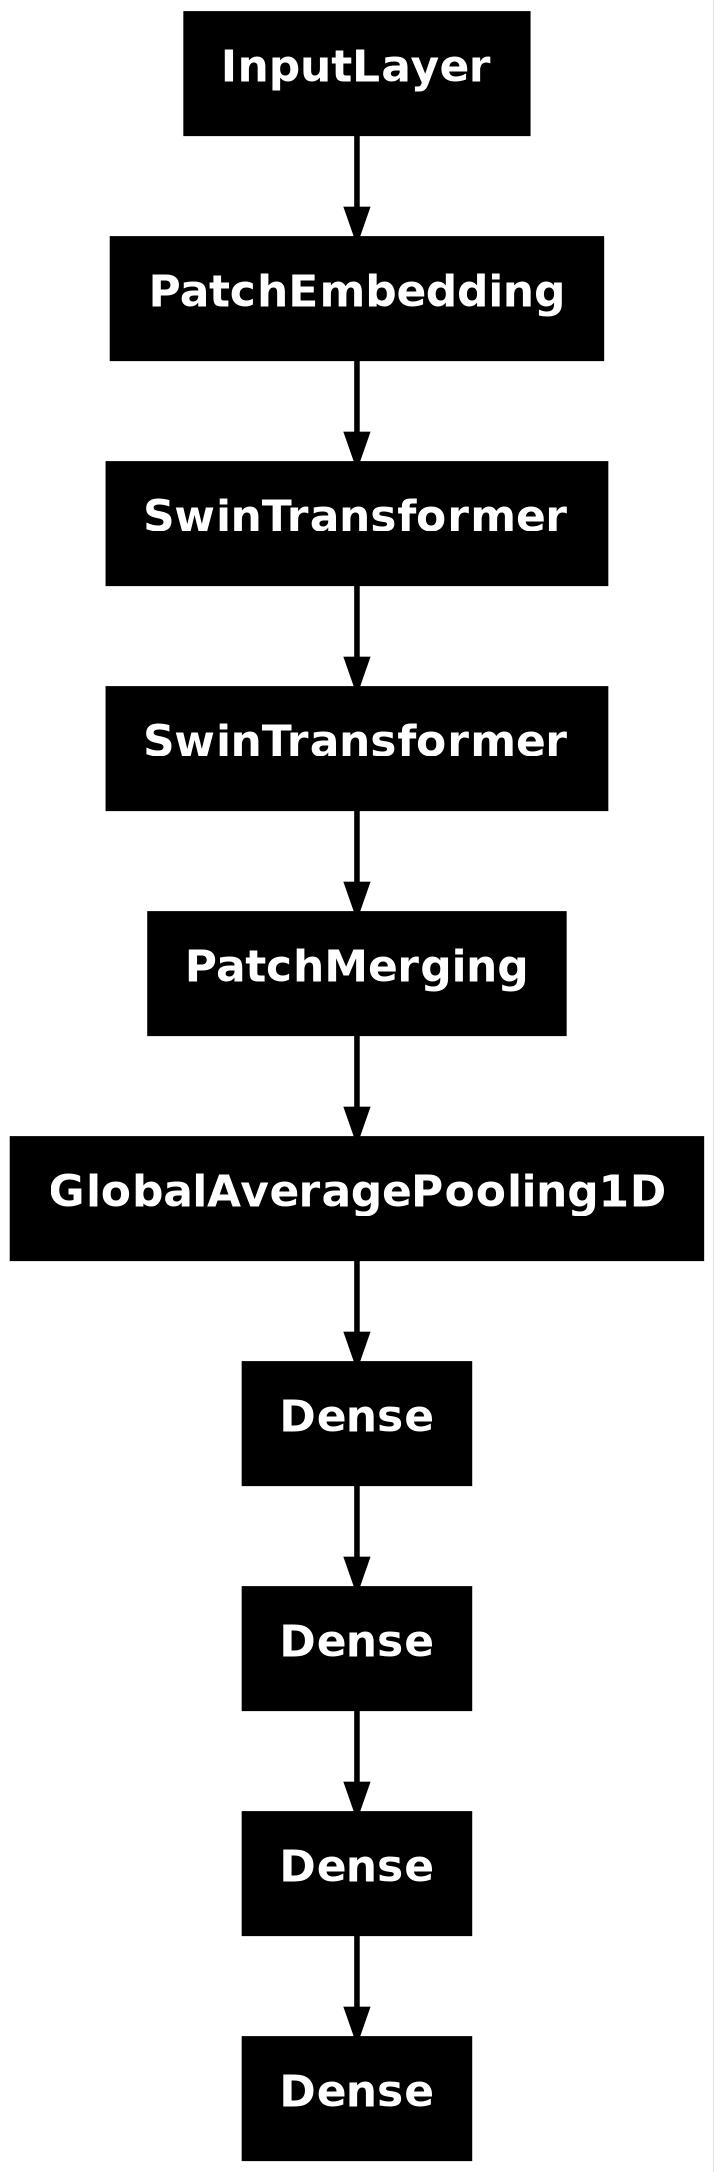

In [44]:
keras.utils.plot_model((model), 'models/swin.jpg')